In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import geomstats.backend as gs
import utils

INFO: Using numpy backend


## Schild's ladder on the sphere

In [2]:
from geomstats.geometry.hypersphere import Hypersphere

sphere = Hypersphere(2)
point = sphere.random_uniform()

tan_a, tan_b = utils.random_orthonormal_sphere(point)

exact_transport = sphere.metric.parallel_transport(tan_a, tan_b, point)
exact_transport_tan_b = sphere.metric.parallel_transport(tan_b, tan_b, point)

### Vizualisation

<IPython.core.display.Javascript object>


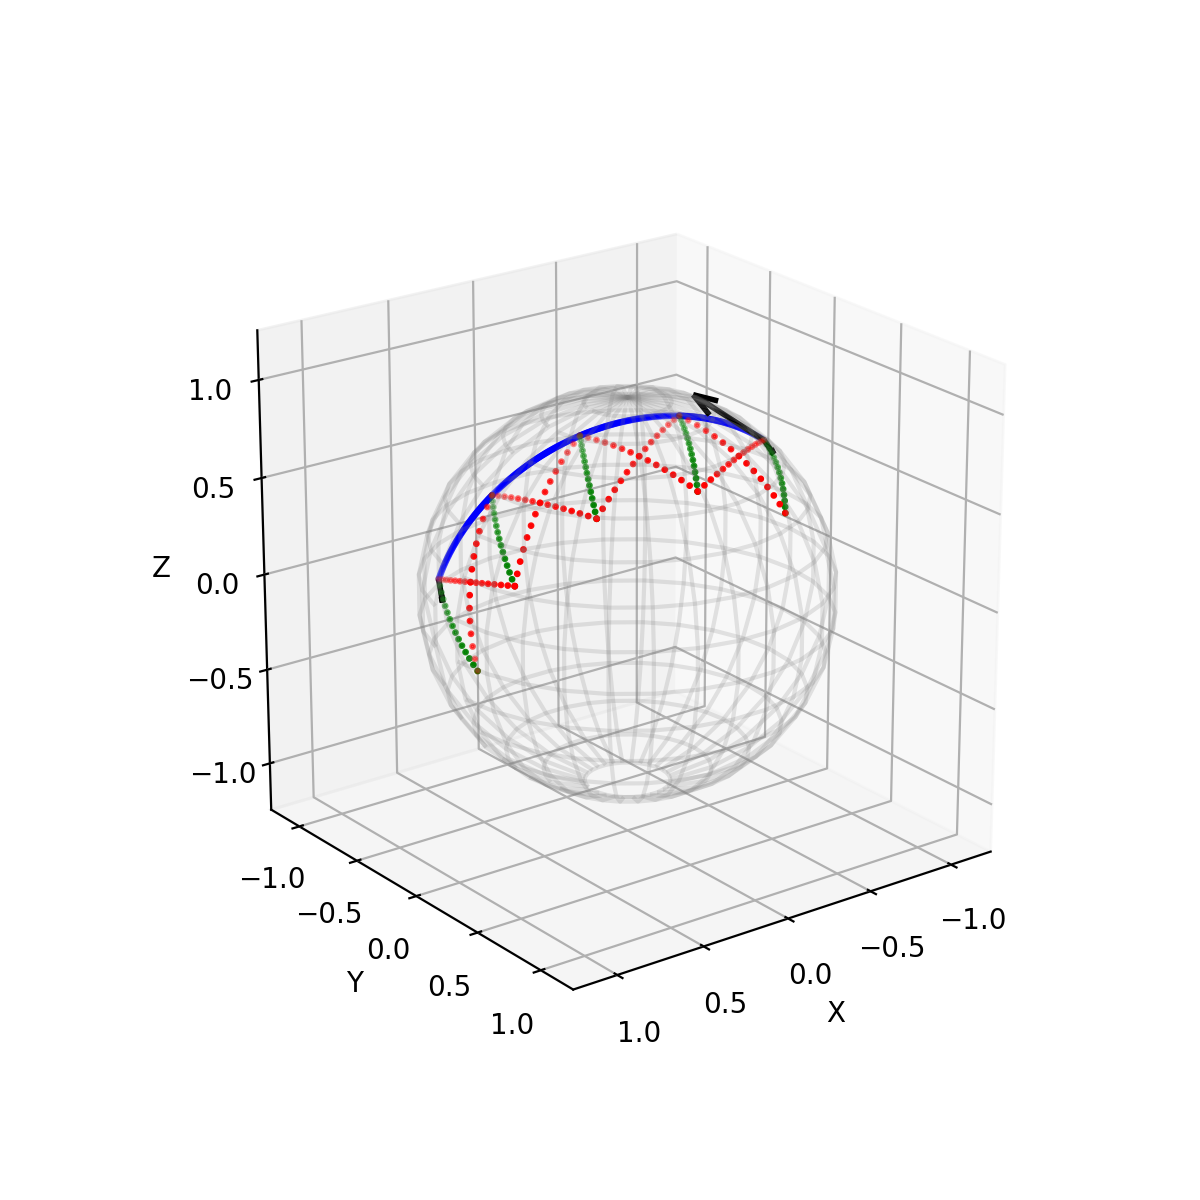

In [3]:
from utils import show_schild

fig = show_schild(tan_a / 2, tan_b * 2, point)
fig.show()

In [3]:
from numpy import logspace

n_numbers = 20
n_range = [int(k) for k in logspace(1, 2.5, n_numbers)]

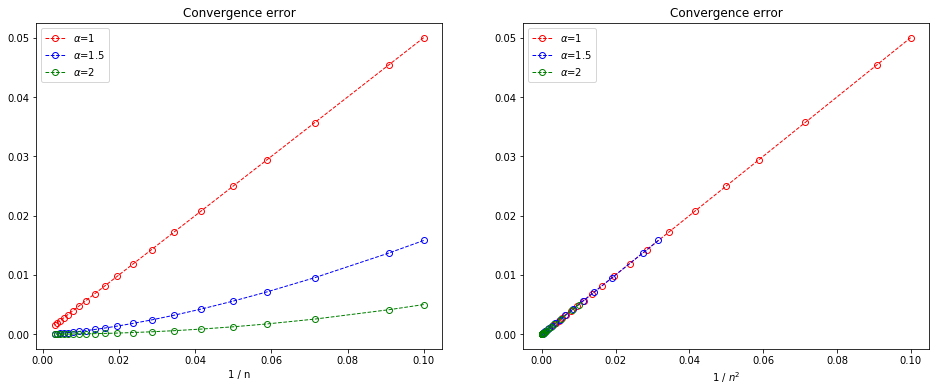

In [4]:
plt.figure(figsize=(16, 6));
ax_abs = plt.subplot(121)
ax_long = plt.subplot(122)
for alpha, col in zip([1, 1.5, 2], ['r', 'b', 'g']):
    abs_error = []
    longitudinal_error = []

    for n_rungs in n_range:

        ladder = sphere.metric.ladder_parallel_transport(
            tan_a / n_rungs ** alpha, tan_b, point,
            n_rungs=n_rungs, scheme='schild')
        transported = ladder['transported_tangent_vec'] * n_rungs ** alpha
        
        abs_error.append(gs.linalg.norm(transported - exact_transport))
        longitudinal_error.append(
            sphere.metric.inner_product(transported - exact_transport, exact_transport_tan_b))
    
    utils.make_plot(ax_abs, abs_error, [1 / k for k in n_range], col=col, label=rf'$\alpha$={alpha}')
    utils.make_plot(
        ax_long, longitudinal_error, [1 / k ** alpha for k in n_range], col=col, label=rf'$\alpha$={alpha}',
        xlabel = r'1 / $n^2$')
plt.show()

## Schild's ladder for SPD matrices

In [ ]:
from geomstats.geometry.spd_matrices import SPDMatrices, SPDMetricAffine

spd = SPDMatrices(3)
metric = SPDMetricAffine(3)
point = spd.random_uniform()

tan_a, tan_b = utils.random_orthonormal_spd(point)

exact_transport = metric.parallel_transport(tan_a, tan_b, point)
exact_transport_tan_b = metric.parallel_transport(tan_b, tan_b, point)
end_point = metric.exp(tan_b, point)

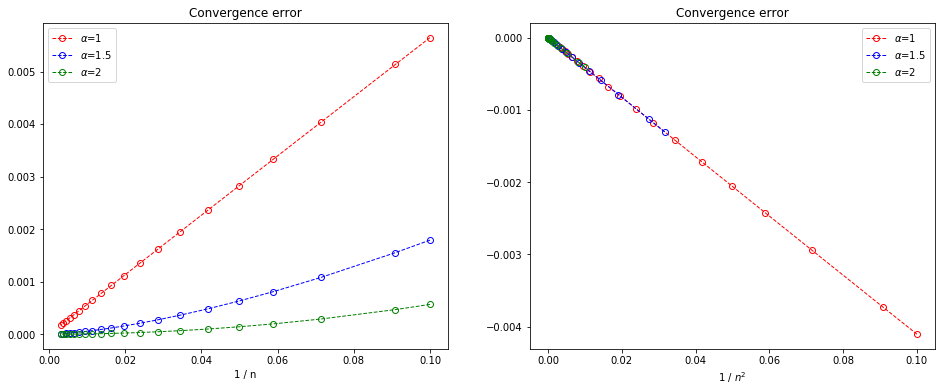

In [6]:
plt.figure(figsize=(16, 6));
ax_abs = plt.subplot(121)
ax_long = plt.subplot(122)
for alpha, col in zip([1, 1.5, 2], ['r', 'b', 'g']):
    abs_error = []
    longitudinal_error = []
    
    for n_rungs in n_range:
        ladder = metric.ladder_parallel_transport(
            tan_a / n_rungs ** alpha,
            tan_b,
            point,
            n_rungs=n_rungs,
            scheme='schild')
        transported = ladder['transported_tangent_vec'] * n_rungs ** alpha
        
        abs_error.append(metric.norm(transported - exact_transport, point))
        longitudinal_error.append(
            metric.inner_product(transported - exact_transport, exact_transport_tan_b,
                                 end_point))
    
    utils.make_plot(ax_abs, abs_error, [1 / k for k in n_range], col=col, label=rf'$\alpha$={alpha}')
    utils.make_plot(
        ax_long, longitudinal_error, [1 / k ** alpha for k in n_range], col=col, label=rf'$\alpha$={alpha}',
        xlabel = r'1 / $n^2$')
plt.show()

## Infinitesimal scheme on SE(3)

In [12]:
from sen_tools.sen import SenTools
from geomstats.geometry.special_euclidean import SpecialEuclidean

tools = SenTools(3)
space = SpecialEuclidean(3)

gs.random.seed(0)
point = space.random_uniform()

n_numbers = 10
n_range = [int(k) for k in logspace(1, 2, n_numbers)]

### Verification of lemme 1

By default $\beta=1$, i.e, the metric is isotropic and we can verify that the covariant derivative of the curvature is identically zero:

In [13]:
is_symmetric = True
for x in tools.basis:
    for i, y in enumerate(tools.basis):
        for z in tools.basis[i:]:
            for t in tools.basis:
                if not gs.isclose(tools.nabla_curvature(x, y, z, t), 0).all():
                    is_symmetric = False
print(is_symmetric)

True


On the other hand, we can set $\beta=2$ and verify that there exists vectors $x,y,z,t$ in the Lie algebra for which $\nabla_x R(y,z)t \neq 0 $:

In [14]:
tools.set_anisotropic_metric(2)
is_symmetric = True
for x in tools.basis:
    for i, y in enumerate(tools.basis):
        for z in tools.basis[i:]:
            for t in tools.basis:
                if not gs.isclose(tools.nabla_curvature(x, y, z, t), 0).all():
                    is_symmetric = False
print(is_symmetric)

False


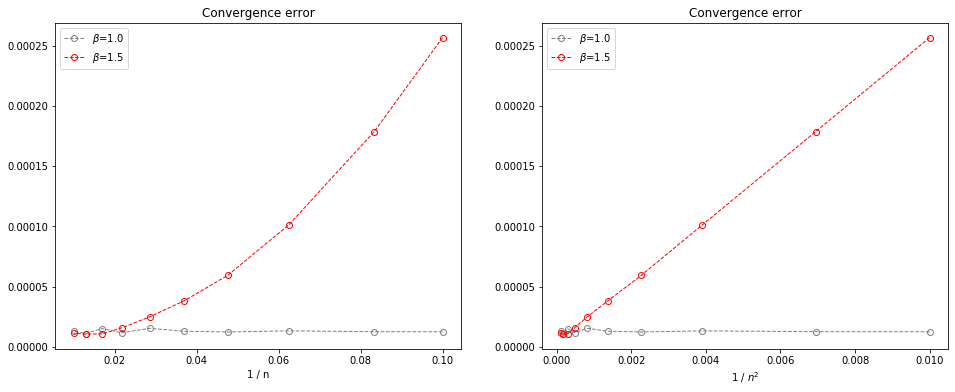

In [8]:
plt.figure(figsize=(16, 6));
ax_abs = plt.subplot(121)
ax_straight = plt.subplot(122)
for beta, col in zip([1., 1.5],  ['gray', 'r', 'b', 'g']):
    tools.set_anisotropic_metric(beta)
    
    # take orthonormal basis vectors that don't change when changing the metric
    tan_a = tools.basis[0]
    tan_b = tools.basis[4]
    tan_b = space.compose(point, tan_b)
    tan_a = space.compose(point, tan_a)

    # exact parallel transport
    exact_transport, end_point = tools.parallel_transport(tan_a, tan_b, point)
    exact_transport_tan_b = tools.log(tools.exp(2 * tan_b, point, n_steps=20), end_point, tol=1e-14, n_steps=20)

    abs_error = []
    longitudinal_error = []
    for n_rungs in n_range:
        ladder, end_point = tools.pole_ladder(
            tan_a / n_rungs, tan_b, point, n_rungs=n_rungs, step='rk4', n_steps=1, tol=1e-14)
        transported = ladder * n_rungs
        abs_error.append(tools.norm(transported - exact_transport, end_point))

    utils.make_plot(ax_abs, abs_error, [1 / k for k in n_range], col=col, label=rf'$\beta$={beta}')
    utils.make_plot(
        ax_straight, abs_error, [1 / k ** 2 for k in n_range], col=col, label=rf'$\beta$={beta}',
        xlabel = r'1 / $n^2$')
plt.show()